<h1 style="margin-bottom: 3px;">
  <hr style="border:none; height:3px;">
  <center>PFITZER PROJECT</center>
  <hr style="border:none; height:3px;">
</h1>

<h2 style="text-align:center; margin-top: 3px;">Assigning Sales Representatives to a Territory</h2>

<p><center><strong>Group 19:</strong> Abderrahmane DKOUR, Malek BOUHADIDA, Yuxian ZUO</center></p>


# Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from gurobipy import Model, GRB, quicksum

from load import load_data_22_4, load_data_100_10
from utils import *

# Table of Contents
- [Step1](#Step1)
- [Step2](#Step2)
- [Step3](#Step3)
- [Step4](#Step4)

# Step1
First, we load the data provided.

In [2]:
distances, workloads, current_assignment, bricks_distances = load_data_22_4()

## Two Mono-Objective Linear Optimization Models
The easiest approch to start with is by formulating **two mono-objective linear optimization models**, one for the distance objective and one for the disruption objective.

**Models:**

1. **Distance Minimization**: Minimize the total travel distance for Sales Representatives (SRs).
2. **Disruption Minimization**: Minimize disruption by assigning bricks as close as possible to their current SR assignments.

**Parameters:**

Let:

- $I = \{1, 2, \dots, 22\}$: Set of bricks.  
- $J = \{1, 2, 3, 4\}$: Set of Sales Representatives (SRs).  
- $d_{ij}$: Distance between SR $j$'s center brick and brick $i$.  
- $w_i$: Workload index value of brick $i$.  
- $x_{ij}$: Binary decision variable (1 if brick $i$ is assigned to SR $j$, 0 otherwise).  
- $c_{ij}$: Binary parameter (1 if brick $i$ is currently assigned to SR $j$, 0 otherwise).  

**Objectives:**

Distance Minimization:
$$
Z_1 = \min \sum_{i \in I} \sum_{j \in J} d_{ij} \cdot x_{ij}
$$

Disruption Minimization:
$$
Z_2 = \min \sum_{i \in I} \sum_{j \in J} w_i \cdot |x_{ij} - c_{ij}|
$$

where $|x_{ij} - c_{ij}|$ accounts for reassignment.

**Constraints:**

1. Each brick is assigned to exactly one SR:  
$$
\sum_{j \in J} x_{ij} = 1, \quad \forall i \in I
$$

2. Workload constraints: e.g., the workload for each SR must be balanced between 0.8 and 1.2:  
$$
0.8 \leqslant \sum_{i \in I} w_i \cdot x_{ij} \leqslant 1.2, \quad \forall j \in J
$$

### Distance Minimization Model

We can start by implementing and solving the distance minimization problem for an instance with 22 bricks and 4 SRs. We choose [0.8 , 1.2] as the accepted workload interval.

In [3]:
bricks = range(22)
SRs = range(4)

In [4]:
def mono_objective_distance(workload_min, workload_max, workloads, distances, bricks, SRs):

    model = Model("Distance Minimization")
    # Variables
    x = model.addVars(22, 4, vtype=GRB.BINARY, name="x")

    # Objective Function
    model.setObjective(quicksum(distances[i][j] * x[i, j] 
                                        for i in bricks for j in SRs), GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    # Optimization
    model.optimize()
    
    return model, x

In [ ]:
model_dist, x_dist = mono_objective_distance(workload_min=0.8,
                                            workload_max=1.2, 
                                            workloads=workloads, 
                                            distances=distances, 
                                            bricks=bricks, 
                                            SRs=SRs)

In [6]:
print_new_assignment(model=model_dist, x=x_dist, SRs=SRs, bricks=bricks)

Optimal Value: 154.59999999999997
SR 1 was assigned bricks: [4, 5, 6, 7, 8, 9, 12, 19, 20]
SR 2 was assigned bricks: [11, 13, 14, 18]
SR 3 was assigned bricks: [10, 15, 16, 17]
SR 4 was assigned bricks: [1, 2, 3, 21, 22]


### Disruption Minimization Model

We now move to the resolution of the disruption minimization problem. We use the same instance and the same workload interval.

In [7]:
def mono_objective_disruption(workload_min, workload_max, workloads, current_assignment, bricks, SRs):

    model = Model("Disruption Minimization")

    # Variables
    x = model.addVars(22, 4, vtype=GRB.BINARY, name="x")

    # Objective Function
    model.setObjective(
        quicksum(workloads[i] * (x[i, j] - 2*current_assignment[i, j]*x[i, j] + current_assignment[i, j])
                 for i in bricks for j in SRs), GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)

    # Optimization
    model.optimize()
    
    return model, x

In [ ]:
model_disrup, x_disrup = mono_objective_disruption(workload_min=0.8, 
                                                workload_max=1.2, 
                                                workloads=workloads, 
                                                current_assignment=current_assignment, 
                                                bricks=bricks, 
                                                SRs=SRs)

In [9]:
print_new_assignment(model=model_disrup, x=x_disrup, SRs=SRs, bricks=bricks)

Optimal Value: 1.0202
SR 1 was assigned bricks: [1, 2, 3, 4, 5, 11, 20]
SR 2 was assigned bricks: [6, 7, 8, 9, 12, 17, 21]
SR 3 was assigned bricks: [10, 13, 14]
SR 4 was assigned bricks: [15, 16, 18, 19, 22]


## Epsilon-Constraint Minimization Model

Instead of minimizating the distance and disruption objectives seperately, we can use the epsilon-constraint scheme to minimize them at the same time.

For that we choose the distance as the main objective, and the disruption as a constraint, below a certain value ε.

In [16]:
def solve_epsilon_constraint_binary(epsilon, workload_min, workload_max, workloads, distances, current_assignment, bricks, SRs):
    
    model = Model("Epsilon-Constraint-Binary")
    
    # Variables
    x = model.addVars(len(bricks), len(SRs), vtype=GRB.BINARY, name="x")
        
    # Objective Function
    distance = quicksum(distances[i, j] * x[i, j] 
                        for i in bricks for j in SRs)
    model.setObjective(distance, GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)
    # Diruption constraint
    disruption = quicksum(workloads[i] * (x[i, j] - 2*current_assignment[i, j]*x[i, j] + current_assignment[i, j]) 
                          for i in bricks for j in SRs)
    model.addConstr(disruption <= epsilon)
    
    # Optimization
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in SRs if x[i, j].X > 0.5]
    return None, None, None

We then compute and represent the corresponding sets of non-dominated solutions, with interval workload constraints [0.8, 1.2], [0.85, 1.15], [0.9, 1.1].

In [17]:
workload_ranges = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

In [ ]:
all_results = {}
delta_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # Start with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint_binary(epsilon=epsilon, 
                                                                           workload_min=workload_min, 
                                                                           workload_max=workload_max,
                                                                           workloads=workloads,
                                                                           distances=distances,
                                                                           current_assignment=current_assignment,
                                                                           bricks=bricks,
                                                                           SRs=SRs)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - delta_epsilon
        else:
            break

    non_dominated_solutions = filter_non_dominated(solutions)
    all_results[(workload_min, workload_max)] = non_dominated_solutions

The below graph represents the non dominated solutions found, for each workload range. In fact, the tighter the workload range is, the worse the solutions are.

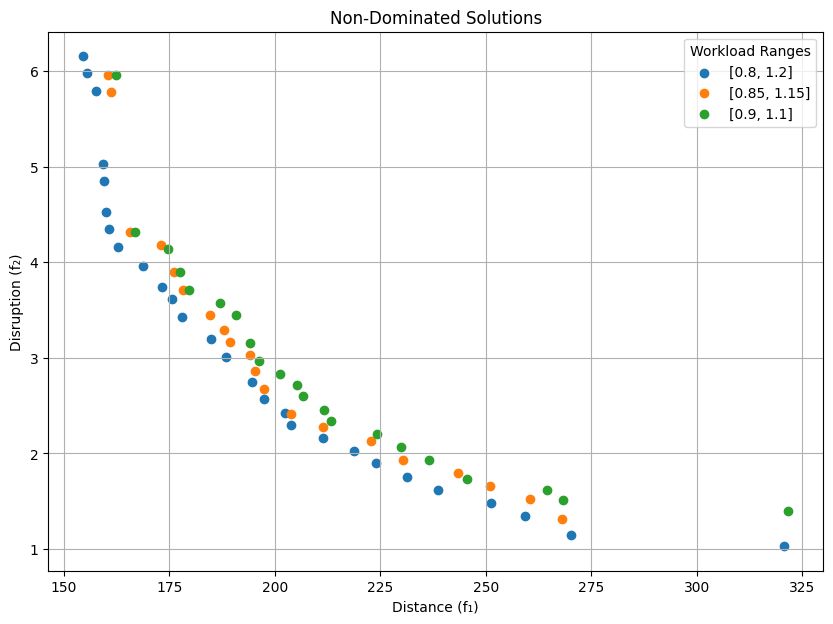

In [20]:
plot_decision_space(all_results, plot_title="Non-Dominated Solutions")

## Step2

### Scalability
To test the scalability of our optimization model, we choose to solve the minimization problem with a bigger instance, namely 100 bricks and 10 SRs. 

We first load the corresponding data.

In [21]:
distances_100, workloads_100, current_assignment_100, brick_locations_100 = load_data_100_10()

In [22]:
bricks_100 = range(100)
SRs_100 = range(10)

We use the same optimization model, but with the new data. The below cell takes around 40s to execute, so we can conclude that our model is scalable!

In [ ]:
all_results_100 = {}
delta_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # Start with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint_binary(epsilon=epsilon, 
                                                                           workload_min=workload_min, 
                                                                           workload_max=workload_max,
                                                                           workloads=workloads_100,
                                                                           distances=distances_100,
                                                                           current_assignment=current_assignment_100,
                                                                           bricks=bricks_100,
                                                                           SRs=SRs_100)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - delta_epsilon
        else:
            break

    non_dominated_solutions = filter_non_dominated(solutions)
    all_results_100[(workload_min, workload_max)] = non_dominated_solutions

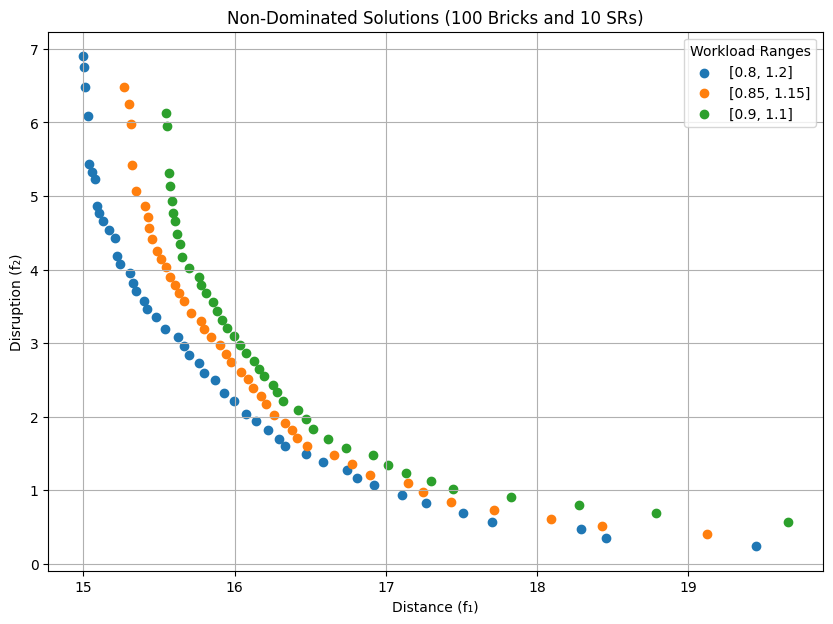

In [24]:
plot_decision_space(all_results_100, plot_title="Non-Dominated Solutions (100 Bricks and 10 SRs)")

### Partal Assignment of bricks

Instead of assigning a brick to one SR, we can relax this constraint and accept the sharing of bricks between SRs. To model that, $x_{ij}$ will no longer be binary but rather continuous.

Another important modificationin the previous code would be to change the disruption formula as we no longer have $(x_{ij} - c_{ij})^2$ = $|x_{ij} - c_{ij}|$. We need to use an additional variable $h_{ij}$ to model the absolute value $|x_{ij} - c_{ij}|$.

A trick would be to add the following constraints
$$
h_{ij} \geqslant x_{ij} - c_{ij}  \text{  and  }  h_{ij} \geqslant -(x_{ij} - c_{ij})
$$

In [25]:
def solve_epsilon_constraint_partial(epsilon, workload_min, workload_max, workloads, distances, current_assignment, bricks, SRs):
    
    model = Model("Epsilon-Constraint-Partial")
    
    # Variables
    x = model.addVars(len(bricks), len(SRs), vtype=GRB.CONTINUOUS, lb=0, ub=1, name="x")
    h = model.addVars(len(bricks), len(SRs), vtype=GRB.CONTINUOUS, name="h")

    
    # Objective Function
    distance = quicksum(distances[i, j] * x[i, j] 
                        for i in bricks for j in SRs)
    model.setObjective(distance, GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in SRs) == 1)
    # Workload constraints for each SR
    for j in SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)
    # Absolute value trick
    for i in bricks:
        for j in SRs:
            model.addConstr(h[i, j] >= x[i, j] - current_assignment[i, j])
            model.addConstr(h[i, j] >= -(x[i, j] - current_assignment[i, j]))

    # Disruption constraint (sum of weighted absolute differences)
    disruption = quicksum(workloads[i] * h[i, j] for i in bricks for j in SRs)
    model.addConstr(disruption <= epsilon)
    
    # Optimization
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in SRs if x[i, j].X > 0.5]
    return None, None, None

In [ ]:
all_results = {}
delta_epsilon = 0.1

for workload_min, workload_max in workload_ranges:
    solutions = []
    epsilon = np.inf  # Start with epsilon as infinity
    
    while True:
        distance, disruption, assignment = solve_epsilon_constraint_partial(epsilon=epsilon, 
                                                                            workload_min=workload_min, 
                                                                           workload_max=workload_max,
                                                                           workloads=workloads,
                                                                           distances=distances,
                                                                           current_assignment=current_assignment,
                                                                           bricks=bricks,
                                                                           SRs=SRs)
        if distance is not None:
            solutions.append((epsilon, distance, disruption, assignment))
            epsilon = disruption - delta_epsilon
        else:
            break

    non_dominated_solutions = filter_non_dominated(solutions)
    all_results[(workload_min, workload_max)] = non_dominated_solutions

In the plot of the non dominated solutions, we clearly see the expected linear shape.

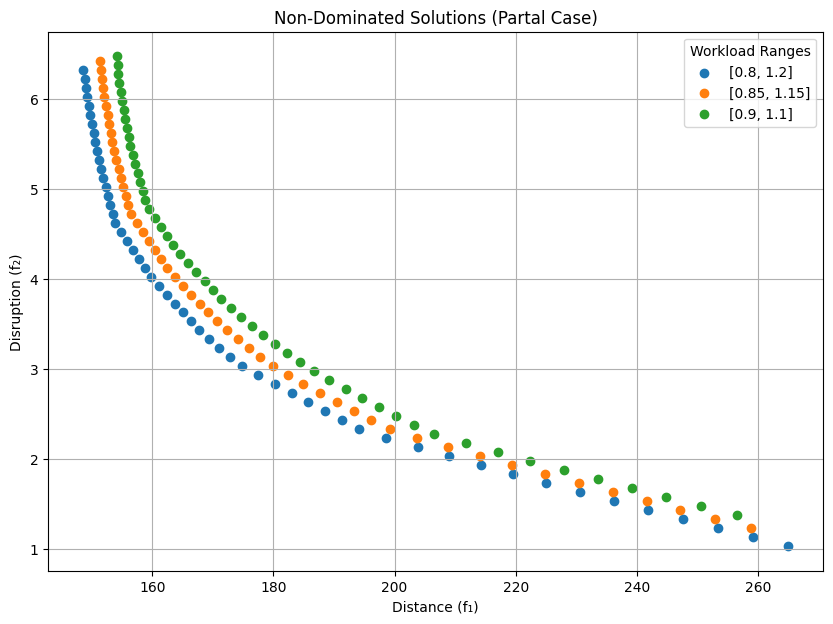

In [27]:
plot_decision_space(all_results, plot_title="Non-Dominated Solutions (Partal Case)")

### New SR

In this section, we suppose that the demand has increased uniformly in all bricks (+25%). As we result, we need to hire a new SR and chose an optimal office to this new SR.

The new office is a center of a brick that is not occupied by any SR. That means two SRs cannot have their offices in the same bricks, so we have 18 possible offices left for the new SR.

To solve this location problem, we can solve our epsilon-constraint problem for each possible office among the 18 bricks and look for the best ones.

In [28]:
extended_SRs = range(5)
adjusted_workloads = {i: workloads[i] * 1.25 for i in bricks}

occupied_bricks = np.where(np.any(distances == 0, axis=1))[0].tolist()

In [29]:
def solve_epsilon_constraint_new_SR(epsilon, workload_min, workload_max, workloads, distances, current_assignment, bricks, SRs):
    
    model = Model("Epsilon-Constraint-New-SR")
        
    # Variables
    x = model.addVars(len(bricks), len(SRs), vtype=GRB.BINARY, name="x")
        
    # Objective Function
    distance = quicksum(distances[i, j] * x[i, j] 
                        for i in bricks for j in extended_SRs)
    model.setObjective(distance, GRB.MINIMIZE)

    # Constraints
    # Each brick is assigned 100%
    for i in bricks:
        model.addConstr(quicksum(x[i, j] for j in extended_SRs) == 1)
    # Workload constraints for each SR
    for j in extended_SRs:
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) >= workload_min)
        model.addConstr(quicksum(workloads[i] * x[i, j] for i in bricks) <= workload_max)
    # Diruption constraint
    disruption = quicksum(workloads[i] * (x[i, j] - current_assignment[i, j]) * (x[i, j] - current_assignment[i, j]) 
                          for i in bricks for j in range(len(SRs)-1))
    model.addConstr(disruption <= epsilon)
    
    # Optimization
    model.optimize()
    
    if model.status == GRB.OPTIMAL:
        return model.objVal, disruption.getValue(), [(i, j) for i in bricks for j in extended_SRs if x[i, j].X > 0.5]
    return None, None, None

In [ ]:
total_results = {}
delta_epsilon = 0.1

for i in tqdm(bricks):
    if i not in occupied_bricks:
        epsilon = np.inf
        solutions = []
        extended_distances = np.column_stack((distances, np.round(bricks_distances[str(i)].to_numpy(), 2)))
        while True:
            distance, disruption, assignment = solve_epsilon_constraint_new_SR(epsilon=epsilon,
                                                                               workload_min=0.8, 
                                                                               workload_max=1.2,
                                                                               workloads=adjusted_workloads,
                                                                               distances=extended_distances,
                                                                               current_assignment=current_assignment,
                                                                               bricks=bricks,
                                                                               SRs=extended_SRs)
            if distance is not None:
                solutions.append((epsilon, distance, disruption, assignment))
                epsilon = disruption - delta_epsilon
            else:
                break

        non_dominated_solutions = filter_non_dominated(solutions)
        total_results[str(i)] = non_dominated_solutions

We can visualise the results and see that not all bricks provide optimal solutions. For example, the choice of the SR's office is in **brick 3** gives us non optimal solutions, always, compared to the other possible center bricks.

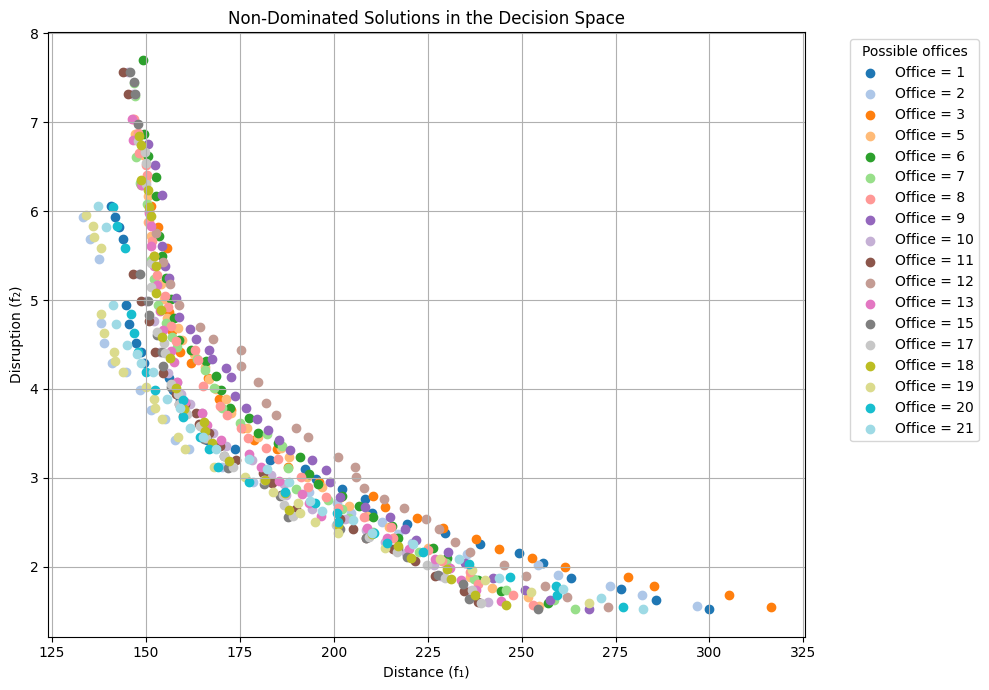

In [32]:
plot_non_dominated_across_all_offices(total_results)

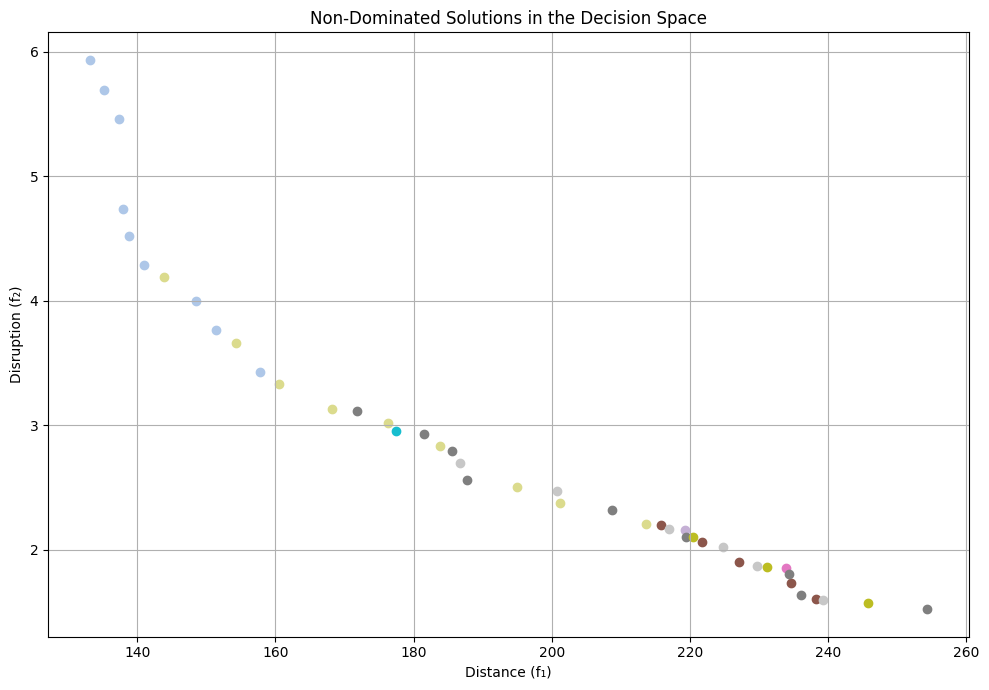

In [33]:
plot_globally_non_dominated_across_all_offices(total_results)